In [1]:
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def plot_histo(bin_edges, counts, image, header):
    """Uses matplotlib to graph a histogram based on output from numpy np.histogram()"""
    plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge')
    plt.yscale('log')
    # Add titles and labels
    plt.title(f'Histogram of Counts in Image {image.name} ({header["OBJECT"]}) (Log Scale)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    # Show the plot
    plt.show()

In [3]:
image_bias_1 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1004.fits")
image_bias_2 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1005.fits")

image_domeflat_1 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1017.fits")
image_domeflat_2 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1018.fits")

image_skyflat_1 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1036.fits")
image_skyflat_2 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1035.fits")

image_obj_1 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1062.fits")
image_obj_2 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1063.fits")

# image_obj_1 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1055.fits")
# image_obj_2 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1056.fits")

# image_obj_1 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1072.fits")
# image_obj_2 = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-proc/unbias/d1073.fits")


images = [image_bias_1, image_bias_2, image_domeflat_1, image_domeflat_2, image_obj_1, image_obj_2]
images = [image_bias_1, image_bias_2, image_skyflat_1, image_skyflat_2, image_obj_1, image_obj_2]

# images = [image_domeflat_1, image_domeflat_2,]

In [4]:
bin_width = 20
num_images = len(images)

obj_counts = {}
data_all = {}
bins_all = {}
data_avg_all = {}
data_diff_all = {}

for i, image in enumerate(images):
    with fits.open(image) as hdu:
        header = hdu[0].header
        
        objname = header["OBJECT"]
        if objname not in data_all:
            obj_counts[objname] = 0
            data_all[objname] = []
            bins_all[objname] = []
            data_diff_all[objname] = []
        
        data_single = hdu[0].data
        # Delete hot columns / cool columns
        data_single = np.delete(data_single, [256, 783, 784, 1002], axis=1)

        data_all[objname].append(data_single)
        obj_counts[objname] += 1
        
        # # Calculate number of histogram bins, based on range of data
        # num_bins = int((np.max(data_single)-np.min(data_single))/bin_width) + 1
        # # Create the histogram -- counts = frequency within each bin, bin_edges = values at bin boundaries
        # counts, bin_edges = np.histogram(data_single, bins=num_bins)
        
        # # Plot histogram using matplotlib
        # plot_histo(bin_edges, counts, image, header)

Calculate the average pixel value between all images of the same object/type

In [5]:
data_avg_max_all = []
data_avg_min_all = []

for objname in obj_counts:
    data_avg = np.stack(data_all[objname]).mean(axis=0)
    data_avg_all[objname] = np.stack(data_all[objname]).mean(axis=0)
    data_avg_max_all.append(np.max(data_avg))
    data_avg_min_all.append(np.min(data_avg))
    for i in range(obj_counts[objname]):
        data_diff_all[objname].append(data_all[objname][i] - data_avg)
data_avg_max = max(data_avg_max_all)
data_avg_min = min(data_avg_min_all)

Fill the histogram bins with the actual pixel values that fall within their range

In [6]:
num_bins_all = int((data_avg_max-data_avg_min)/bin_width) + 1
bins_avgs = [[] for _ in range(num_bins_all)]
bins_diffs = [[] for _ in range(num_bins_all)]

for objname in obj_counts:
    for index, value in np.ndenumerate(data_avg_all[objname]):
        bin_index = int(np.floor((value - data_avg_min) / bin_width))
        for i in range(obj_counts[objname]):
            bins_diffs[bin_index].append(data_diff_all[objname][i][*index])
        bins_avgs[bin_index].append(value)

Create a histogram of all the values in just one bin

In [7]:
counts_per_bin = [len(bin) for bin in bins_diffs]
bin_to_analyze = np.argmax(counts_per_bin)

def bin_histo(bins, bin_index):
    # Create the histogram -- counts = frequency within each bin, bin_edges = values at bin boundaries
    subcounts, subbin_edges = np.histogram(bins[bin_index], bins=int(bin_width), )
    # Plot histogram using matplotlib
    plot_histo(subbin_edges, subcounts, image, header)

# bin_histo(bins_diffs, bin_to_analyze)

Find the mean and standard deviation for all bins

In [8]:
means = []
sds = []

# for i, bins in enumerate(bins_all):
for bin_index in range(len(bins_diffs)):
    if len(bins_diffs[bin_index]) > 50:
        sd = np.std(bins_diffs[bin_index])
        mean = np.mean(bins_avgs[bin_index])
        if sd != 0 and mean > 0 and mean < 55000:
            means.append(mean)
            sds.append(sd)

def plot_means_sds(means, sds, image, header):
    # Plot the scatter plot
    plt.scatter(means, sds)
    plt.xscale('log')
    plt.yscale('log')
    # Add titles and labels
    plt.title(f'SD vs. Mean Plot for {image.name} ({header["OBJECT"]})')
    plt.xlabel('Mean of all values in a bin')
    plt.ylabel('Standard Deviation of all values in a bin')
    # Show the plot
    plt.show()

# plot_means_sds(means, sds, image, header)


log(SD) = 1.16 log(mean) + -3.86


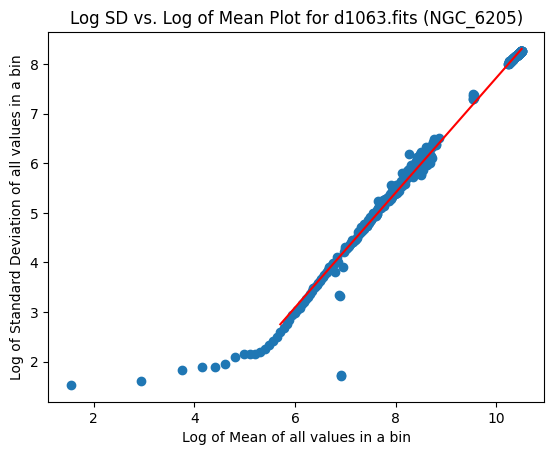

In [9]:
meanlogs = [math.log(mean) for mean in means]
sdlogs = [math.log(sd) for sd in sds]

meanlogs_linear = meanlogs[15:]
sdlogs_linear = sdlogs[15:]

# Calculate the line of best fit
coefficients = np.polyfit(meanlogs_linear, sdlogs_linear, 1)  # 1 means linear fit (degree 1)
polynomial = np.poly1d(coefficients)
line_of_best_fit = polynomial(meanlogs_linear)

print(f"log(SD) = {coefficients[0]:.2f} log(mean) + {coefficients[1]:.2f}")

# Plot the scatter plot
plt.scatter(meanlogs, sdlogs)
# Plot the line of best fit
plt.plot(meanlogs_linear, line_of_best_fit, color='red', label='Line of Best Fit')

# Add titles and labels
plt.title(f'Log SD vs. Log of Mean Plot for {image.name} ({header["OBJECT"]})')
plt.xlabel('Log of Mean of all values in a bin')
plt.ylabel('Log of Standard Deviation of all values in a bin')

# Show the plot
plt.show()

In [10]:
# from display_fits import print_fits_info

# for image in images:
#     print_fits_info(image)